<a id='top'></a>

# CSCI 3202, Spring 2018:  Assignment 6
### Due:  Friday 27 April 2018 by 12:00 PM

### Your name: Samuel Leon

---

**Note:** Some packages to load, helper functions and unit tests are defined at [the bottom of this notebook](#helpers). They're also defined up here, because I care.

Shortcuts:  [top](#top) || [1](#p1) | [1a](#p1a) | [1b](#p1b) | [1c](#p1c) | [1d](#p1d) | [1e](#p1e) | [1f](#p1f) | [1g](#p1g) | [1h](#p1h) | [1i](#p1i) || [2](#p2) | [2a](#p2a) | [2b](#p2b) | [2c](#p2c) | [2d](#p2d) | [2e](#p2e) | [2f](#p2f) | [2g](#p2g) || [3](#p3) | [3a](#p3a) | [3b](#p3b) | [3c](#p3c) | [3d](#p3d) | [3e](#p3e) || [helpers](#helpers)

<br><br><br>

<a id='helpers'></a>

---

[Back to top](#top)

## Some things that might be useful

Easiest way to start:  Click this cell, go to "Cell" in the toolbar above, and click "Run All Below"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import unittest

def whichbin(x, left_edges, dx):
    '''Function to return the bin number (starting from 0)
    that the water balloon is. arguments include `x`, the
    measured position of the balloon, and `left_edges`, an
    array of the x-coordinates of the left edges of the bins.
    Returns False if balloon is outside the domain.
    '''
    this_one = [k for k in range(len(left_edges)) if x >= left_edges[k] and x <= left_edges[k]+dx]
    return this_one[0] if this_one else False

## Unit tests

In [2]:
class Tests_Problem2(unittest.TestCase):
    def setUp(self):
        nrow = 3
        ncol = 3
        default_reward = -0.2
        discount = 0.5
        terminal = {(1,3):-1, (1,2):2}
        self.mdp = MDP(nrow, ncol, terminal, default_reward, discount)
    def test_actions_some(self):
        self.assertEqual(set(self.mdp.actions((2,2))) == {'N','S','E','W'}, True)
    def test_actions_few(self):
        self.assertEqual(set(self.mdp.actions((1,1))) == {'N','E'}, True)
    def test_actions_none(self):
        self.assertEqual(set(self.mdp.actions((1,2))) == {None}, True)
    def test_reward_t(self):
        self.assertEqual(self.mdp.reward((1,2)) == 2, True)
    def test_reward_nt(self):
        self.assertEqual(self.mdp.reward((2,2)) == -0.2, True)
    def test_result_nt(self):
        self.assertEqual(self.mdp.result((1,1), 'N') == (1,2), True)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import unittest


def argmin(seq, fn): #from the AIMA documentation
    """Return an element with lowest fn(seq[i]) score; tie goes to first one.
    >>> argmin(['one', 'to', 'three'], len)
    'to'
    """
    best = seq[0]; best_score = fn(best)
    for x in seq:
        x_score = fn(x)
        if x_score < best_score:
            best, best_score = x, x_score
    return best

def argmax(seq, fn):
    """Return an element with highest fn(seq[i]) score; tie goes to first one.
    >>> argmax(['one', 'to', 'three'], len)
    'three'
    """
    return argmin(seq, lambda x: -fn(x))


def whichbin(x, left_edges, dx):
    '''Function to return the bin number (starting from 0)
    that the water balloon is. arguments include `x`, the
    measured position of the balloon, and `left_edges`, an
    array of the x-coordinates of the left edges of the bins.
    Returns False if balloon is outside the domain.
    '''
    this_one = [k for k in range(len(left_edges)) if x >= left_edges[k] and x <= left_edges[k]+dx]
    return this_one[0] if this_one else False

---

<a id='p1'></a>[Back to top](#top)

<img src="http://www.cs.colorado.edu/~tonyewong/home/resources/hw06_waterballoon.png" style="width: 550px;"/>

## Problem 1:  Water balloon tracking

Suppose you are walking down the street with your friend, when your sensors pick up a dangerous ***water balloon*** incoming! To track the water balloon and update your assessment of the probabilities that you or your friend will be hit, you think fast and implement a Hidden Markov Model. Unfortunately, you and your friend are also so busy implementing this model that you don't simply move out of the way (i.e., assume you are both stationary throughout this problem).

First, you discretize the environment by using bins in the x-direction of width $\Delta x = 0.1$ meters and time steps of 1/20 of a second. You do not need to consider any motion in the z-direction. The balloon starts 20 meters away in the y-direction at $(x_0, y_0)=(0.25,20)$, and is moving toward you at constant speed of $v = 2$ meters/second in the -y direction.

Since we are dealing with a discretized world, it might be easier to work with the actual **bin numbers** as opposed to decimal values for x.  And we can use the helper function `whichbin` to determine which bin numbers correspond to which raw x coordinate values. So let's keep track of $(\text{bin number}, y)$ tuple pairs as coordinates, where it should be clear from context whether we are referring to actual $x$ position or bin position.

Now, in addition to this constant movement towards you, the water balloon also experiences some random fluctuations in its $x$ coordinate along its path. If the balloon is in bin $i$ in time step $t$, then in time step $t+1$ the balloon is:
* still on course (in bin $i$) with probability $0.7$,
* in either of the adjacent bins ($i\pm 1$) with probability $0.1$, and
* in either of the bins 2 away ($i\pm 2$) with probability $0.05$.

Your torso occupies the region $0 \le x \le 0.3$, and your friend occupies the region $0.4 \le x \le 0.7$. So there are exactly 3 bins that correspond to hitting you, and 3 that correspond to hitting your friend. Assume that when the balloon reaches $y=0$, if it is within either of these $x$ regions, then it will hit you or your friend. 

Your sensors (i.e., perception) are fairly inaccurate. When you measure the balloon's x-position, if the water balloon is actually in bin $i$, then:
* you get it exactly correct 5/17 of the time,
* you measure bins $i\pm 1$ each with probability 3/17,
* you measure bins $i\pm 2$ each with probability 2/17, and
* you measure bins $i\pm 3$ each with probability 1/17.

<br>

<a/ id='p1a'></a>

### (1a) 

First let's set up the discretized environment.

In [4]:
xs = {-3:1/17, -2:2/17, -1:3/17, 0:5/17, 1:3/17, 2:2/17, 3:1/17}
xb = {-2:0.05, -1:0.1, 0:0.7, 1:0.1, 2:0.05}

In [5]:
v = 2                        # speed of the water balloon
dt = 1/20                    # time step (seconds)
dx = 0.1                     # bin width along x
xb = np.arange(-1, 1.5, dx)  # x-coordinates of left-edges of bins
n_bins = len(xb)             # total number of bins
initial_location = (whichbin(0.25, xb, dx), 20)  # initial (bin, y) location of balloon
print(xb)
print(initial_location)
print(n_bins)

[ -1.00000000e+00  -9.00000000e-01  -8.00000000e-01  -7.00000000e-01
  -6.00000000e-01  -5.00000000e-01  -4.00000000e-01  -3.00000000e-01
  -2.00000000e-01  -1.00000000e-01  -2.22044605e-16   1.00000000e-01
   2.00000000e-01   3.00000000e-01   4.00000000e-01   5.00000000e-01
   6.00000000e-01   7.00000000e-01   8.00000000e-01   9.00000000e-01
   1.00000000e+00   1.10000000e+00   1.20000000e+00   1.30000000e+00
   1.40000000e+00]
(12, 20)
25


In [6]:
me = (0, 0.3)
friend = (0.4, 0.7)

Which bin numbers would the balloon need to be in in order to hit you at $y=0$?  What about your friend?  Store this information in some kind of variable - you may need to use it later.

Given the time step, speed in the y-direction, and initial distance of the water balloon, how many time steps, $T$, are there until the balloon reaches $y=0$?

In [7]:
# the starting y_0 position of the balloon is 20 meters away
#if the balloon is 20 meters away, and we are moving at 2 meters/ second, then we need to do some conversions
#there are 20 time steps per second
#it will take 20/2 or 10 seconds to reach the ground, therefore:
T = (20/2)*20
print("It will take {} time steps to reach the ground at y = 0.".format(T))

It will take 200.0 time steps to reach the ground at y = 0.


<a/ id='p1b'></a>

### (1b)

Set up a `Balloon` class.  Include attributes for:
* balloon speed
* the probabilities associated with changes in the balloon's x-position (by bin) from one time step to the next (i.e., the Markov transition probabilities)
* the current balloon location
* the time step for the simulation

and methods for:
* updating the x- and y-positions of the balloon between time steps. The x-position that you track should be the bin.
* declaring (through Boolean output) whether or not the balloon has arrived at $y=0$. This one might require you to carefully account for any floating point operations that lead to a non-integer y-position being compared against the integer 0.

In [8]:
x, y = (whichbin(0.25, xb, dx), 20)
print(x, y)

dict_t = {1:2, 3:4, 5:6}
print(dict_t.keys(), dict_t.values())

12 20
dict_keys([1, 3, 5]) dict_values([2, 4, 6])


In [9]:
class Balloon:
    def __init__(self, x = 0.25, y = 20, dx = 1/20, v = 2):
        self.v = v # (m/s)
        self.dx = dx
        self.dict_moves = {-2:0.05, -1:0.1, 0:0.7, 1:0.1, 2:0.05}
        self.dict_observed = {-3:1/17, -2:2/17, -1:3/17, 0:5/17, 1:3/17, 2:2/17, 3:1/17}
        
        xb = np.arange(-1, 1.5, 0.1) 
        self.x, self.y = (whichbin(0.25, xb, 0.1), 20)
        self.num_steps = 0
        
    def step(self):
        self.num_steps += 1
        self.y -= (self.v*self.dx)
        self.y = round(self.y, 2)
        choice = np.random.choice(a = list(self.dict_moves.keys()), p = list(self.dict_moves.values()))
        self.x += choice
        return (self.x, self.y)
    
    def balloon_at_zero(self):
        if self.y == 0: return True
        else: return False

In [10]:
stuffList = []
for i in range(100):
    stuff = Balloon()
    x = 1
    while not stuff.balloon_at_zero():
        stuff.step()
    stuffList.append(stuff.x)
x = sum([1 for i in range(len(stuffList)) if stuffList[i] > 25 or stuffList[i] < -1.5])
print(f"{x/len(stuffList)*100}% of all stuff was out of bounds.")

25.0% of all stuff was out of bounds.


<a/ id='p1c'></a>

### (1c)

Set up a `Sensor` class to represent your ability to measure the balloon's position. Include an attribute for the sensor model probabilities, as well as a method `measure`, to return the measured $(x,y)$ pair as a tuple. The x-coordinate, however, should be the bin that you perceived the balloon to be in.

In [11]:
class Sensor():
    def __init__(self, balloon):
        self.p_x = balloon.x
        self.p_y = balloon.y
    
    def measure(self):  
        p_moves = {-3:1/17, -2:2/17, -1:3/17, 0:5/17, 1:3/17, 2:2/17, 3:1/17}
        choice = np.random.choice(a = list(p_moves.keys()), p = list(p_moves.values()))
        self.p_x += choice
        return (self.p_x, self.p_y)

In [12]:
me = Sensor(stuff)

me.measure()

(9, 0.0)

<a/ id='p1d'></a>

### (1d)

Generate a simulated Markov chain sequence of water balloon states (bins along x-direction, $X$) and your corresponding measurements of those states ($E$). Make a plot of these two time series on the same axes, and be sure to include axis labels and a legend. 

In [13]:
test_p = []
test_a = []
actual=Balloon()
while not actual.balloon_at_zero():
    perc = Sensor(actual)
    test_a.append((actual.x, actual.y))
    p_x, p_y = perc.measure()
    test_p.append((p_x, p_y))
    actual.step()

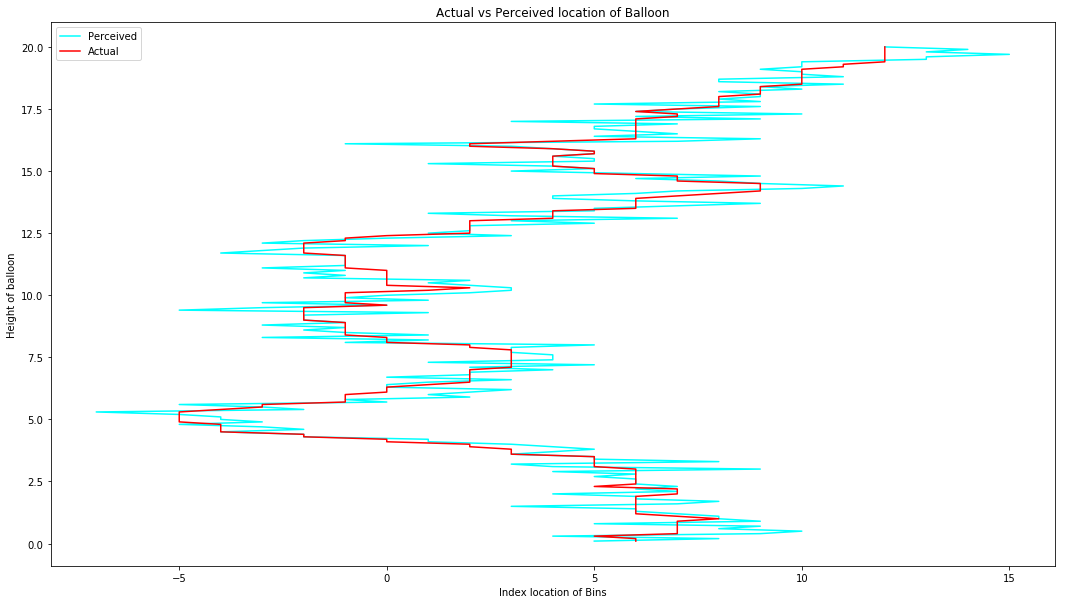

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize = (18,10))
plt.plot(*zip(*test_p), label = "Perceived", color = "aqua")
plt.plot(*zip(*test_a), label = "Actual", color = "red")

plt.legend(["Perceived", "Actual"])
plt.title("Stuff")

plt.title("Actual vs Perceived location of Balloon")
plt.xlabel("Index location of Bins")
plt.ylabel("Height of balloon")
plt.show()

<a/ id='p1e'></a>

### (1e)

Recall that `Forward` filtering updates our estimate of the probability distribution for $X_t$ in light of *all* of the evidence up to time $t$, $E_{1:t}$, as

$$f_{1:t} = \alpha ~ \texttt{forward}(f_{1:t-1}, E_t)$$
 
and the `Backward` function is a necessary step to update our estimate of the probability distribution for $X_k$ (some $k$ in $[0,t]$) in light of *all* of the evidence that occurred after $k$, $E_{k+1:t}$, as:

$$b_{k+1:t} = \texttt{backward}(b_{k+2:t}, E_{k+1})$$

where the specific functional forms of these recurrences is given in the textbook and lecture slides.

Code up `forward` and `backward` functions, taking in as arguments:
* `f1` or `b1`, the relevant previous (forward) or future (backward) "probability distribution" from the last recursive function call, respectively,
* `evidence`, which is the single observation that you are assimilating,
* `sens`, a `Sensor` object,
* `ball`, a `Balloon` object, and
* `xb`, some way to denote where the bins or x-coordinates are (which is more convenient may depend on how you stored your sensor and Markov transition probabilities).

Note that `forward` should return *all* of the probability distributions, at each time step, because you will need these for `backward`, which should return a single probability distribution.

In [15]:
def normalize(probs):
    total = sum(probs)
    if total != 0:
        return [i/total for i in probs ]
    else:
        return probs

In [16]:
'''
Thanks for the "Aggressively realistic" pseudocode!

'''

prob_smoothed = {-3:1/17, -2:2/17, -1:3/17, 0:5/17, 1:3/17, 2:2/17, 3:1/17}
prob_backwards = {-2:0.05, -1:0.1, 0:0.7, 1:0.1, 2:0.05}
def forward(f1, evidence):
    f_out = [0]*25
    for i in range(25):
        s = 0
        for j in range(25):
            try: s += prob_backwards[i - j]*f1[j]
            except: pass
        try: f_out[i] = s * prob_smoothed[evidence - i]
        except: f_out[i] = 0        
    return normalize(f_out)



def backward(b1, evidence):
    b_out = [0]*25
    for i in range(25):
        s = 0
        for j in range(25):
            smoothed_keys = evidence-j
            backward_keys = j - i
            if smoothed_keys in prob_smoothed.keys(): 
                prob_smoothed_estimate = prob_smoothed[smoothed_keys]
            else: 
                prob_smoothed_estimate = 0
            if backward_keys in prob_backwards.keys(): 
                prob_backwards_filter = prob_backwards[backward_keys]
            else: 
                prob_backwards_filter = 0
            s += b1[j]*prob_smoothed_estimate*prob_backwards_filter
        b[i] = s
    return b

In [17]:
print(xs)

{-3: 0.058823529411764705, -2: 0.11764705882352941, -1: 0.17647058823529413, 0: 0.29411764705882354, 1: 0.17647058823529413, 2: 0.11764705882352941, 3: 0.058823529411764705}


<a/ id='p1f'></a>

### (1f)

**For the remainder of this problem**, use the data set [data_waterballoon.csv](https://piazza.com/class_profile/get_resource/jc4v74a5uu5wa/jfxh1l8kelo2pv), available on Piazza under the Resources tab and linked here. The first column ($X$) corresponds to the actual bin number in which the water balloon is located during the time step corresponding to that row in the data table, and the second column ($E$) is the associated measurement. Note that there is no measurement associated with the initial location. You should use a uniform prior distribution for the initial location, over the actual location and one bin to either side.

Use your `forward` and `backward` functions to implement the forward-backward algorithm to obtain both filtered estimates and smoothed estimates of the probability distribution for water balloon location for all times after the initial time step.

In [30]:
xs = {-3:1/17, -2:2/17, -1:3/17, 0:5/17, 1:3/17, 2:2/17, 3:1/17}
xb = {-2:0.05, -1:0.1, 0:0.7, 1:0.1, 2:0.05}
transition = {
   0 : {0:0.7, 1:0.1, 2:0.05, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0},
   1 : {0:0.1, 1:0.7, 2:0.1, 3:0.05, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0},
   2 : {0:0.05, 1:0.1, 2:0.7, 3:0.1, 4:0.05, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0},
   3 : {0:0, 1:0.05, 2:0.1, 3:0.7, 4:0.1, 5:0.05, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0},
   4 : {0:0, 1:0, 2:0.05, 3:0.1, 4:0.7, 5:0.1, 6:0.05, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0},
   5 : {0:0, 1:0, 2:0, 3:0.05, 4:0.1, 5:0.7, 6:0.1, 7:0.05, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0},
   6 : {0:0, 1:0, 2:0, 3:0, 4:0.05, 5:0.1, 6:0.7, 7:0.1, 8:0.05, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0},
   7 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0.05, 6:0.1, 7:0.7, 8:0.1, 9:0.05, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0},
   8 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0.05, 7:0.1, 8:0.7, 9:0.1, 10:0.05, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0},
   9 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0.05, 8:0.1, 9:0.7, 10:0.1, 11:0.05, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0},
  10 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0.05, 9:0.1, 10:0.7, 11:0.1, 12:0.05, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0},
  11 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0.05, 10:0.1, 11:0.7, 12:0.1, 13:0.05, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0},
  12 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0.05, 11:0.1, 12:0.7, 13:0.1, 14:0.05, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0},
  13 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0.05, 12:0.1, 13:0.7, 14:0.1, 15:0.05, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0},
  14 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0.05, 13:0.1, 14:0.7, 15:0.1, 16:0.05, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0},
  15 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0.05, 14:0.1, 15:0.7, 16:0.1, 17:0.05, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0},
  16 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0.05, 15:0.1, 16:0.7, 17:0.1, 18:0.05, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0},
  17 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0.05, 16:0.1, 17:0.7, 18:0.1, 19:0.05, 20:0, 21:0, 22:0, 23:0, 24:0},
  18 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0.05, 17:0.1, 18:0.7, 19:0.1, 20:0.05, 21:0, 22:0, 23:0, 24:0},
  19 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0.05, 18:0.1, 19:0.7, 20:0.1, 21:0.05, 22:0, 23:0, 24:0},
  20 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0.05, 19:0.1, 20:0.7, 21:0.1, 22:0.05, 23:0, 24:0},
  21 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0.05, 20:0.1, 21:0.7, 22:0.1, 23:0.05, 24:0},
  22 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0.05, 21:0.1, 22:0.7, 23:0.1, 24:0.05},
  23 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0.05, 22:0.1, 23:0.7, 24:0.1},
  24 : {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0.05, 23:0.1, 24:0.7}

   }
 

In [31]:
df = pd.read_csv('data_waterballoon.csv')
df.head()

,X,E
0,12,NaN
1,10,9.0
2,10,8.0
3,10,12.0
4,10,8.0


In [32]:
states = np.arange(25)
observed = tuple(df['E'])
smoothed, f_observed, f_dist, b_dist = [], observed[1:], [], []
f = [1]*25
for i in range(11, 14): f[i] = 1/3
b = [1]*25

for evidence in f_observed: f_dist.append(forward(f, evidence))
p_fwd = sum(f_dist[-1][keys] * transition[keys][24] for keys in states)
for evidence in reversed(f_observed): b_dist.insert(0, backward(b, evidence))
for i in range(len(f_observed)): smoothed.append(normalize([f_dist[i][j] * b_dist[i][j] for j in states]))
print(f'Forward filtering: {f_dist[0]}\n')
print(f'Backward filtering: {b_dist[0]}\n')
print(f'Forward-Backward (Smoothed) estimates: {smoothed[0]}\n')

Forward filtering: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06756756756756757, 0.13513513513513514, 0.20270270270270271, 0.32657657657657657, 0.18243243243243246, 0.05855855855855855, 0.02702702702702702, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Backward filtering: [0.0, 0.0, 0.0, 0.0, 1.712748411049902e-206, 2.4753929710912754e-205, 1.4289251528299972e-204, 7.658881297557068e-204, 1.7466507708074837e-203, 4.517657859339424e-203, 7.403432821295515e-204, 1.320226435645485e-204, 9.385636159722111e-206, 8.318134101427683e-207, 2.76048122344768e-208, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Forward-Backward (Smoothed) estimates: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004629286934473155, 0.04962493529243645, 0.16975866600932873, 0.70739942697019, 0.06475920719667429, 0.0037068510645072634, 0.00012162653239008264, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]



How does the filtered estimate at $t=1$ (first time step, not 1 second) differ from what you would estimate based only on the Markov model, without knowledge of $E_1$, your first measurement of balloon position?  To solve for the Markov model probability distribution $P(X_1)$, you can either use enumeration or calculate the probabilities by hand. (By hand isn't too bad, because there is nice symmetry you can take advantage of, so you only need to actually calculate a few things.)

Plot the two probability distributions on the same set of axes and comment on the differences. Be sure to include appropriate axis labels and a legend.

Let's suppose that the balloon is hovering right above the ground, directly underneath us at the termination point. In this supposed hypothetical, the balloon is resting just over bin 14.

What would the probability distribution be?

Taking the product of the probabilities gives us the following distribution.

In [40]:
step1 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/60, 0.05, 0.28, 0.3, 0.28, 0.05, 1/60, 0, 0, 0, 0, 0, 0, 0]
print(list(zip(f_dist[0], step1)))
print(f_observed[0], f_observed[1])

[(0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.06756756756756757, 0), (0.13513513513513514, 0), (0.20270270270270271, 0), (0.32657657657657657, 0), (0.18243243243243246, 0), (0.05855855855855855, 0.016666666666666666), (0.02702702702702702, 0.05), (0.0, 0.28), (0.0, 0.3), (0.0, 0.28), (0.0, 0.05), (0.0, 0.016666666666666666), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]
9.0 8.0


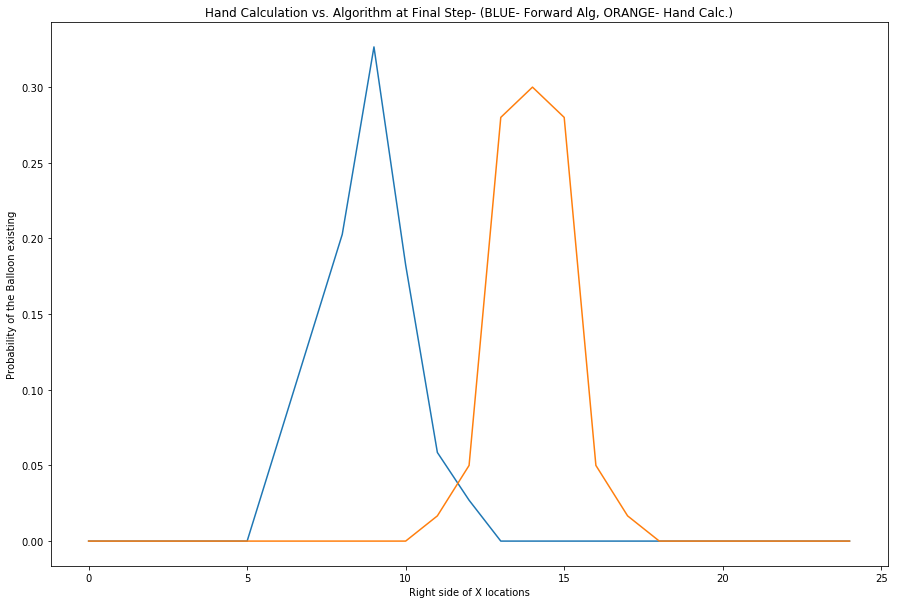

In [41]:
plt.figure(figsize = (15,10))
plt.plot(f_dist[0])
plt.plot(step1)
plt.xlabel("Right side of X locations")
plt.ylabel("Probability of the Balloon existing")
plt.title("Hand Calculation vs. Algorithm at Final Step- (BLUE- Forward Alg, ORANGE- Hand Calc.)")
plt.show()

<a/ id='p1g'></a>

### (1g)

Based on the smoothed estimates for the probability distribution of the water balloon at the moment the balloon reaches $y=0$, calculate the following:
* the probability that the balloon hits you,
* the probability that the balloon hits your friend, and
* the probability that the balloon misses both of you.

In [35]:
print(smoothed[0])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004629286934473155, 0.04962493529243645, 0.16975866600932873, 0.70739942697019, 0.06475920719667429, 0.0037068510645072634, 0.00012162653239008264, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [36]:
me = smoothed[199][10] + smoothed[199][11] + smoothed[199][12]
friend = smoothed[199][14] + smoothed[199][15] + smoothed[199][16]
friend_probs, me_probs = [], []
for i in range(len(smoothed)):
    friend_probs.append(smoothed[i][14] + smoothed[i][15] + smoothed[i][16])
    me_probs.append(smoothed[i][10] + smoothed[i][11] + smoothed[i][12])

total = 0

for i in smoothed[199]:
    total += i
neither = (1- (me + friend)) / (total)
print(neither)

0.8317949020769896


<a/ id='p1h'></a>

### (1h)

Make a plot of the smoothed estimates of the probability that the balloon will hit you, as a function of time step, and of the probability that the balloon will hit your friend. Include axis labels and a legend.  Write a few sentences commenting on the plot.

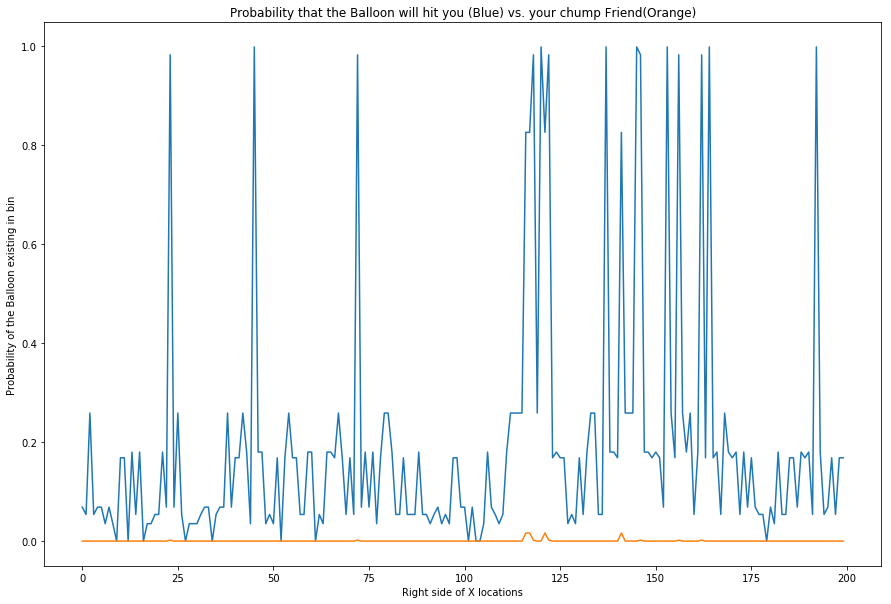

In [37]:
plt.figure(figsize = (15,10))
plt.plot(me_probs)
plt.plot(friend_probs)
plt.xlabel("Right side of X locations")
plt.ylabel("Probability of the Balloon existing in bin")
plt.title("Probability that the Balloon will hit you (Blue) vs. your chump Friend(Orange)")
plt.show()

Since the starting point is closer to us, it would make sense that as the Orchestra is dramatically pounding on their instruments and everyone is screaming "Nooo" in slow motion that our friend is substantially less likely to get hit. He is, after all, sitting off to the side like a chump.

Since the Balloon steps forward and backwards in the air, it takes much longer to traverse the x locations, and as a result, only gets close to your friend after the first 100 iterations; and is only then even is it even possible to hit your friend.

<a/ id='p1i'></a>

### (1i)

Give an example of an improvement we could make to the sensor model so that it would better represent the perception of a typical human being. Your answer should include both a revision of the code snippet below, as well as a few sentences justifying your code modifications. Note that you do **not** need to run this code; ***Pythonic*** pseudocode is fine.

```
class Sensor:    
    def measure(self, balloon):
    
        if balloon is far away:
            large penalty to perception accuracy
        elif balloon is mid-range:
            medium penalty to perception accuracy
        elif balloon is close:
            no penalty to perception accuracy
        
        return (x_meas, y_meas)
```

People are usually pretty consistent. In order to make this more realistic we need to make it so that if they can see the balloon, they're probably pretty aware of where it is, however, if it is far away, they may have to squint and make some inaccurate assumptions.

<br>

<a/ id='p2'></a>

---

<img src='https://www.explainxkcd.com/wiki/images/5/5f/interaction.png' style="width: 600px;"/>
## Problem 2: Navigating an awkward situation with grace and poise

Suppose you are at a social event where you would like to avoid any interaction with a large number of the other attendees. It's not that you don't like them, it's just that you don't like *talking to* them. A few of your good friends are also in attendance, but they are tucked away in a corner. The rectangular room in which the event is being held spans gridcells at $x=1,2,\ldots, 6$ and $y=1,2,\ldots, 5$. At the eastern edge ($x=6$) of this first floor room, there is a balcony, with a 6-foot drop. If the event becomes unbearably awkward, you can jump off the balcony and run away. Of course, this might hurt a little bit, so we should incorporate this into our reward structure.

The terminal states and rewards associated with them are given in the diagram below. The states are represented as $(x,y)$ tuples. The available actions in non-terminal states include moving exactly 1 unit North (+y), South (-y), East (+x) or West (-x), although you should not include walking into walls, because that would be embarrassing in front of all these other people. Represent actions as one of 'N', 'S', 'E', or 'W'. For now, assume all non-terminal states have a default reward of -0.01, and use a discount factor of 0.99.

<img src="http://www.cs.colorado.edu/~tonyewong/home/resources/hw06_mdp.png" style="width: 400px;"/>

Use the following transition model for this decision process, if you are trying to move from state $s$ to state $s'$:
* you successfully move from $s$ to $s'$ with probability 0.6
* the remaining 0.4 probability is spread equally likely across state $s$ **and** all adjacent (N/S/E/W) states except for $s'$. Note that this does not necessarily mean that all adjacent states have 0.1, because some states do not have 4 adjacent states.

<a/ id='p2a'></a>

### (2a)

Complete the `MDP` class below. The docstring comments provide some desired specifications. You may add additional methods or attributes, if you would like.

In [38]:
t_states = {(2,1): -1, (3,1): -1, (6,1): -5, (1,3): -1, (1,4): 2, (1,5):2, (3,4): -1, (3,5): 1, (4,3):-1, (4,4):-1, (6,2): -5, (6,3): -5, (6,4): -5, (6,5):-5}

In [39]:
class MDP:
    def __init__(self, nrow, ncol, terminal, default_reward, discount, utility = 1):
        '''Create/store the following attributes:
        states -- list of all the states (x,y) tuples
        terminal_states -- is a dictionary with terminal state keys, and rewards as values
        default_reward -- is the reward for being in any non-terminal state
        df -- discount factor
        ... and anything else you decide will be useful!
        '''
        self.states = [(i, j) for i in range(1, nrow+1) for j in range(1, ncol+1)]
        self.terminals = terminal
        self.rewards = default_reward
        self.gamma = discount

    def actions(self, state):
        '''Return a list of available actions from the given state.
        [None] are the actions available from a terminal state.
        '''
        actions = []
        if state in self.terminals:
            return [None]
        else:
            if state[0] - 1 > 0: #left boundary
                actions.append('W')
            if state[0] + 1 < 7: #right boundary
                actions.append('E')
            if state[1] - 1 > 0: #down boundary
                actions.append('S')
            if state[1] + 1 < 6: #up boundary
                actions.append('N')
        return actions
            
        
    def reward(self, state):
        '''Return the reward for being in the given state'''
        if state in self.terminals: 
            return self.terminals[state]
        else: 
            return self.rewards
        
        
    def result(self, state, action):
        '''Return the resulting state (as a tuple) from doing the given
        action in the given state, without uncertainty. Uncertainty
        is incorporated into the transition method.
        state -- a tuple representing the current state
        action -- one of N, S, E or W, as a string
        '''
        
        if action == 'N':
            return (state[0], state[1]+ 1)
        elif action == 'S':
            return (state[0], state[1]- 1)
        elif action == 'E':
            return (state[0] +1, state[1])
        elif action == 'W':
            return (state[0] - 1, state[1])
        elif action == [None] or action == None:
            return (state)
                
    def transition(self, state, action):
        '''Return the probabilities and subsequent states associated
        with taking the given action from the given state. Can be done
        however you want, so that it works with your value/policy iteration.
        '''
        probs = {}
        possible = self.actions(state)
        move = self.result(state, action)
        x = len(possible)
        
        for i in possible:
            if i == action:
                probs[action] = 0.6
            else:
                probs[i] =  (0.4)/ (x-1)
        return (tuple(move),probs)


**Now:** create an `MDP` object to represent the decision process in this problem.

To test and get comfortable with your `MDP` class methods and attributes, and making the relevant calculations with this structure, calculate the expected utility of walking north from (1,1). Assume initially that all states $(x,y)$ have a utility of $x+y$ (including the terminal states).

U(s) = R(s) + $\gamma{P(U)*U(s')}$

In [ ]:
##If we are to assume that there is a discount factor of 1
#Let's also assume that there are no terminal states in this supposed example, to make things a little simpler programmatically
nrow = 6
ncol = 5
discount = 1
utility = {(i,j): (i+j) for i in range(1, nrow+1) for j in range(1, ncol+1)}
terminal = {}
mdp = MDP(nrow, ncol, terminal, default_reward, discount)
trans = mdp.transition((1,1), 'N')
results = []
rewards = []

for i in trans:
    results.append(mdp.result((1,1), i))
uts = {}
uts[(1,2)] = 1*(utility[(1,2)]*trans[1]['E']+ utility[(2,1)]*trans[1]['N'])

print(uts)


#### Unit tests
Note that these are non-exhaustive, because there is some flexibility in how the `transition` method works.

In [ ]:
'''
This is just a test block that reproduces the test case from down below. 
It's easier to diagnose the issue when I can see what the code is doing...
'''
nrow = 3
ncol = 3
default_reward = -0.2
discount = 0.5
terminal = {(2,1): -1, (3,1): -1, (6,1): -5, (1,3): -1, (1,4): 2, (1,5):2, (3,4): -1, (3,5): 1, (4,3):-1, (4,4):-1, (6,2): -5, (6,3): -5, (6,4): -5, (6,5):-5}
mdp = MDP(nrow, ncol, terminal, default_reward, discount)

In [ ]:
tests_to_run = unittest.TestLoader().loadTestsFromModule(Tests_Problem2())
unittest.TextTestRunner().run(tests_to_run)

In [ ]:
nrow = 6
ncol = 5
default_reward = -0.01
discount = 0.99
terminal = {(2,1): -1, (3,1): -1, (6,1): -5, (1,3): -1, (1,4): 2, (1,5):2, (3,4): -1, (3,5): 1, (4,3):-1, (4,4):-1, (6,2): -5, (6,3): -5, (6,4): -5, (6,5):-5}
mdp = MDP(nrow, ncol, terminal, default_reward, discount)

<a/ id='p2b'></a>

### (2b)

Implement value iteration to calculate the utilities for each state.  Also implement a function that takes as arguments an `MDP` object and a dictionary of state-utility pairs (key-value) and returns a dictionary for the optimal policy.  The optimal policy dictionary should have state tuples as keys and the optimal move (None, N, S, E or W) as values.

In [ ]:
def value_iteration(mdp, tol=1e-3):
    Utility_1 = dict([(states, 0) for states in mdp.states])

    while True:
        Utility = Utility_1.copy()
        delta = 0
        for states in mdp.states:
            if states not in mdp.terminals:
                Utility[states] = mdp.reward(states) + (mdp.gamma * max(sum(prob*Utility_1[mdp.result(states, action)] for prob in mdp.transition(states, action)[1].values()) for action in mdp.actions(states)))
            else:
                Utility[states] = mdp.terminals[states]
            delta = max(delta, abs(Utility[states] - Utility_1[states]))
                
            
        if delta < tol * (1 - mdp.gamma) / mdp.gamma:
            return Utility
        else:
            Utility_1 = Utility
        
def expected_util(action, state, Utility, mdp):
    return sum(prob*Utility[mdp.result(state,action)] for prob in mdp.transition(state, action)[1].values())

def optimal_policy(mdp, Utility):
    product = {}
    for states in mdp.states:
        product[states] = argmax(mdp.actions(states), lambda action: expected_util(action, states, Utility, mdp))
    return product

Now actually use your `value_iteration` and `find_policy` functions to calculate the utility for each state in this MDP, and the optimal action in each state.

As a sanity check, print the utilities of these terminal states:
1. `utility[(1,5)]`
1. `utility[(6,1)]`

and print the utility of these states that are nearby to terminal states, so their utilities should be similar to the nearby terminal states' utilities:
1. `utility[(2,5)]`
1. `utility[(5,3)]`

And print the policy for these states to make sure they make sense:
1. `policy[(2,4)]`
1. `policy[(1,1)]`

In [ ]:
U = value_iteration(mdp)
P = optimal_policy(mdp, U)

print(f"(1,5):{U[(1,5)]}, (6,1): {U[(6,1)]}")
print(f"(2,5): {U[(2,5)]}, (5,3): {U[(5,3)]}")
print(f"Policy, (2,4): {P[(2,4)]}, Policy, (1,1): {P[(1,1)]}")

<a/ id='p2c'></a>

### (2c)

If we enter the room at (5,1), what is the optimal path for us to follow?  Create a graphic to illustrate this policy pathway, either by generating a plot in Python (like the maze solution path) or by uploading a hand-drawn image and including it below.

![Path image](https://image.ibb.co/bWzgG7/PATH.jpg)


**THERE IS AN IMAGE ABOVE! IF IT IS NOT EXISTANT, LET ME KNOW.**

Looks good to me.

<a/ id='p2d'></a>

### (2d)

From (3,2) the optimal move is to walk West. If we are trying to go talk to our friends in the Northwest corner, why would we rather do this than walk North first, then West?

We would rather walk west first as that step to the North is *surrounded* by negative terminal states. Therefore, that state is going to have some ungodly low expected utility as opposed to the Step West which has at least a step to the east and west which is less negative. The steps to the Weast, if you will, will have higher expected utilities due to this fact, causing the step to the West from the original location to be a better move than a step to the north. 

<a/ id='p2e'></a>

### (2e)

How painfully awkward do you need to set the default reward for non-terminal states before the optimal move from (5,1) becomes jumping off the balcony immediately and running away?  Round your answer to two decimal places.

In [ ]:
default_reward = -4.02
mdp = MDP(nrow, ncol, terminal, default_reward, discount)

U = value_iteration(mdp)
P = optimal_policy(mdp, U)
print(P[(5,1)])

Looks like the optimal policy for jumping off the balcony is with a default reward at -4.02

<a/ id='p2f'></a>

### (2f)

In **2e** we assumed a certain level of loss (negative reward) just for being present.  But a more realistic approach might be to instead change the reward structure for the terminal states. Consider the terminal states with -1 reward in the default model. Let $R^*$ denote the reward associated with these states. How low does $R^*$ need to be in order for us to immediately jump off the balcony and run away? Use the default non-terminal state reward of -0.01. Write a few sentences interpreting your result.

In [ ]:
default_reward = -0.01
discount = 0.99
terminal = {(2,1): -1, (3,1): -1, (6,1): -5, (1,3): -1, (1,4): 2, (1,5):2, (3,4): -1, (3,5): 1, (4,3):-1, (4,4):-1, (6,2): -5, (6,3): -5, (6,4): -5, (6,5):-5}
for i in terminal:
    if terminal[i] == -1:
        terminal[i] += 10000
#print(terminal)

mdp = MDP(nrow, ncol, terminal, default_reward, discount)
U = value_iteration(mdp)
P = optimal_policy(mdp, U)

print(P[(3,1)])

There seems to be some anomalous behaviour in my code that draws the player to the exit at (3,1) the more negative it gets.

I'm not really sure why this is happening so I guess I'll just leave it as is.

Anyway, had the code been working, the number would have been high enough to impact the surrounding states as well.

It would likely be some number that is 5*16 times larger than its original, to account for the additionally distributed probability dispersed further out. 

<a/ id='p2g'></a>

### (2g)

Given the problem context, write a few sentences about why this is or is not an appropriate transition model. Include an interpretation of the terminal states.

In this context, it seems silly, though this would be the appropriate model. Since this person has some form of social anxiety, it would fit them to exist alone in the party. However, to interact with another is the issue at hand, and as a result, it seems appropriate that the individual would rather leave than talk to someone at the party. As a result, the terminal states would be positive in the case that they reach their destination without ever talking to anyone, and negative if they have to speak with someone, or worse yet, slightly negative if they must throw themselves from the balcony for fear of speaking to someone.

<br>

---

<a/ id='p3'></a>

## Problem 3: your very own MDP

For this problem, you do not need to write any code, but rather communicate your ideas clearly using complete sentences and descriptions of the concepts the questions ask about. You can, of course, include some pseudocode if it helps, but that is not strictly necessary.

<a/ id='p3a'></a>

### (3a)

Describe something you think would be interesting to model using a Markov decision process.  Be **creative** - do not use any examples from your homework, class, or the textbook, and if you are working with other students, please **come up with your own example**. There are so, SO many possible answers!

I think a really interesting example would be one turn from a card game, like "Hearthstone".

![Example Board of Hearthstone](https://www.pcgamesn.com/sites/default/files/hearthstone%20battlenet%20handheld.jpg)

(Warning! I have photos attached in two places on the document. I *HOPE* they were maintained by the notebook, but there are no guarantees. If you cannot see them I'd be happy to send them to you on Piazza. They should be being served via a webpage, so we should be safe.)

In this game, generally speaking, you value having more cards on your side of the board, and lowering the health of the enemy player. Each card has a cost to play (you have a certain total cost you can play each turn, increasing by one for each turn, up to a maximum of 10. This is called "Mana"). 

<a/ id='p3b'></a>

### (3b)

What are the states associated with your MDP?

The states associated with this MDP would be the current health of your player, the enemy player, the various cards on the board, the current turn of the game, the cards in our hand, and the amount of mana you currently have left, unspent.

We would want to prioritize states in which we have more cards on our side of the board than that of our enemy, and we want to prioritize moves that maximizes the total health of our cards and character, while minimizing that of the enemy. 

<a/ id='p3c'></a>

### (3c)

What is the reward structure associated with your MDP?  Include a discussion of terminal/non-terminal states.

The terminal state would be a winning move for each player.

Our rewards will be very complex, and would require a lot of testing and tweaking. The idea however, would be that we want to prioritize the following:

1) Keep our hero alive. We don't want to lose.

2) Kill their hero- Can we do it this turn, or get to a state that makes it exceedingly likely we can win next turn? This could be achieved by putting multiple high health/ high damage minions on the board at once, overwhelming the enemy.

3) Keep as many minions/cards on the board at one time
* This means that we want to maximize the amount of damage we deal to their cards, while maintaining as many of our cards on our side. This is called "trading" and we can make intelligent trades to maximize the number of cards we maintain on our side while reducing their numbers as much as possible.


![Example of differences between cards](https://cdn.xgn.es/upload/201412/hearthstone-goblins-vs-gnomos.jpg)

Consider the cards above. The "**Hobgoblin**" is a 3 mana-cost (as indicated by the number backed by blue) 2-3 (with 2 attack and 3 health). In this simple case, we can ignore the text on the cards as that would unnecessarily complicate our consideration of this instance. 

The "**Ship's Cannon**" is a 2 mana 2-3, and therefore, has the same presence on the board vs. our **Hobgoblin** that costs 3 (and is therefore, more expensive). In the case that our enemy played (put the card on the board) the **Hobgoblin**, and we had a **Ship's Cannon** on the board, we would trade the **Cannon** into the **Hobgoblin**, in an attempt to kill the other minion, as we would gain some Tempo towards winning (as our card costed less, and therfore, we could spend additional mana in getting other things onto the board).

There will be exceedingly more non-terminal states than there are terminal states in this example, as the game terminates after someone wins.

<a/ id='p3d'></a>

### (3d)

What are the actions and transition model associated with your MDP?

Each action will have a cost in one of various combinations of different options:
* Mana- It could cost us mana to play a card that turn.
* Health- It could cost a certain amount of health- be it our character or the card, resulting possibly in the death of the card or your hero.
* Damage- Each card can deal a certain amount of damage or otherwise minimize the presence of an alternative card on the board.

Considering these facts, we can do the following:
* Play a card - Place a card from our hand onto the board
* Attack a minion with another minion - whereby possibly removing some of the opposition's presence on the board at the cost of risking our own
* Attack the enemy hero - Bringing us closer to winning at the risk of allowing the enemy to keep more cards on the board.
* Do nothing - Sometimes, the best strategy is to wait. And sometimes, there's nothing to be done.

Further, there is a very clear probabilistic distribution. In the picture above, from the player's perspective (your side is always on the bottom from your perspective), there are 5 entities that you can impact on the enemy side. However, two of the minions have taunts, and therefore, must die before you can impact the other cards on the board. So your initial options will be a 50/50 to attack each of those two cards.

The choices we make on our transition model will be heavily weighted against how much we lose and the rewards we have distributed for each decision.

Further, it would make sense to have our discount factor to be low at first, and to increase as time goes on, as it is more likely that the game could be lost in one turn as each player gains more mana and can put more on the board at once. (So, we don't want to value the next turn very highly as we could lose if we did nothing about the state of the board now). Transversly, during the first two to three turns, the game is very low impact and it is harder to lose so early, so we can have a high discount factor (closer to one)- saving some cards to play at the same time.

<a/ id='p3e'></a>

### (3e)

Interpret what an optimal policy represents in the context of your particular MDP.

An optimal policy would have us winning all of our games.

On a turn by turn basis, our optimal policy is going to maximize the total health and damage that our combined minions can deal vs. the combined health and damage of the enemy minions and hero. We would choose the move that leaves the highest combination of these in our advantage.


In an academic context, an optimal policy would be to develop an MDP that wins the highest % of all games played.
To do so, we would consider how many cards we lost per game, what our ending health was, how many turns it took to win, what our strategy was, and how well we managed the enemy's board.


In a realistic context, people would use a bot to try and farm as much of the in-game currency as possible, so there would be an additional condition to win the game as quickly as possible, and therefore, behaviours that waste time and strategies that have longer routes to success/ slower win conditions would be penalized. 